In [55]:
import numpy as np
import csv
import pandas as pd
from scipy.optimize import curve_fit
from src import *
import matplotlib.pyplot as plt
import os


# OCC

In [2]:
 # from the meta analysis: https://inldigitallibrary.inl.gov/sites/sti/sti/Sort_107010.pdf\n# Table 29
 # # Large reactors
 
 OCC_large_conservative = 7750 # USD/kW
 OCC_large_moderate = 5750
 cons_duration_large_conservative = 125 #(months)
 
 cons_duration_large_moderate = 82 #(months)
 power_large_ref = 1000 # MWe
 
 # SMR
 OCC_SMR_conservative = 10000 # USD/kW
 OCC_SMR_moderate = 7750 
 cons_duration_SMR_conservative = 71 #(months)
 cons_duration_SMR_moderate = 55 #(months)
 power_SMR_ref = 200 # MWe # the average power of the SMR in the sheet is 200 
 
 
 #Microreactors\n# from the lit review : https://www.osti.gov/biblio/1986466: Table 17 (scaled data) only OCC. The data that had the financing cost were excluded
 # # all of them are multuplied by 1.175625 (inflation multuplier from 2019 to 2023) using :https://fred.stlouisfed.org/series/GDPDEF#0\n
 MR_cost_1  = 10000 * 1.175625 
 MR_cost_2 = + 15000 *1.175625
 MR_cost_3 =  20000 * 1.175625
 MR_cost_4 = 3996 * 1.175625  
 MR_cost_5 = 8276  * 1.175625 
 MR_cost_6 = 14973 * 1.175625
 MR_cost_average =np.mean ([MR_cost_1,MR_cost_2, MR_cost_3, MR_cost_4,MR_cost_5, MR_cost_6 ])
 MR_cost_std = np.std ([MR_cost_1,MR_cost_2, MR_cost_3, MR_cost_4,MR_cost_5, MR_cost_6 ])
 
power_micro_ref = 5 # MW
cons_duration_micro_conservative = 36 #(months) # I assumed this!
 
OCC_micro_conservative = MR_cost_average + MR_cost_std # USD/kW
OCC_micro_moderate = MR_cost_average
 
 # now lets do curve fitting\n
def large_reactor_func(x, a, b):  
    return a*(x**b)

xdata1 = [ power_large_ref,  power_SMR_ref,power_micro_ref ]
ydata1 = [ OCC_large_conservative,  OCC_SMR_conservative, OCC_micro_conservative  ]
popt1, p_cov1 = curve_fit(large_reactor_func, xdata1 , ydata1)

def occ_for_power(P):
    return popt1[0] *(P**popt1[1]) # $/kw

def construction_duration_power(P):
    if P > 500:
        duration =  cons_duration_large_conservative
    if P <= 500 and P > 50:
         duration =  cons_duration_SMR_conservative
    elif P<= 50:     
        duration =  cons_duration_micro_conservative
    return duration



print("OCCs for large, small, microreactors are : " , OCC_large_conservative,  OCC_SMR_conservative, OCC_micro_conservative , "$/kw" )

OCCs for large, small, microreactors are :  7750 10000 20297.3421381159 $/kw


# TCI

In [3]:
def capital_investment(P, interest_rate):
    construction_duration = construction_duration_power(P)
    tot_overnight_cost = occ_for_power(P)
    
    # Interest rate from this equation (from Levi)
    B =(1+ np.exp((np.log(1+ interest_rate)) * construction_duration/12))
    C  =((np.log(1+ interest_rate)*(construction_duration/12)/3.14)**2+1)
    Interest_expenses = tot_overnight_cost*((0.5*B/C)-1)
    return (Interest_expenses + tot_overnight_cost) # this is TCI in $/kw

def tot_TCI_multiple_reactors (P, interest_rate, num_reactors): # multiple reactors of the same power

    # the capital investment of one reactor ($/kw)
    levlized_TCI = capital_investment(P, interest_rate)
    
    if P >500:
        learning_rate = 0.08
    elif P<=500 :
        learning_rate = 0.095 
    
    # the capital investment of one reactor ($/kw) after the learning rate effect
    final_TCI = calculate_final_cost_due_to_learning_rate(levlized_TCI, learning_rate, num_reactors ) # This is still cost per kw
    final_TCI_one_reactor = final_TCI *P*1000 #(Dollar)
    final_TCI_all_reactors = final_TCI_one_reactor *num_reactors 
    return final_TCI_all_reactors # (dollars)

interest_rate = 0.06
print("TCIs for large, small, microreactors are : " ,\
    np.round(capital_investment( power_large_ref, interest_rate), 0),  np.round(capital_investment( power_SMR_ref, interest_rate), 0),\
        np.round(capital_investment(power_micro_ref , interest_rate), 0), "$/kw" )

print("Total TCIs for large, small, microreactors are : " , np.round(tot_TCI_multiple_reactors( power_large_ref, interest_rate, 1)/1000000000, 2),\
    np.round(tot_TCI_multiple_reactors( power_SMR_ref, interest_rate, 1)/1000000000, 2), np.round(tot_TCI_multiple_reactors(power_micro_ref , interest_rate, 1)/1000000000, 2), "USD (billions)" )

TCIs for large, small, microreactors are :  10331.0 12154.0 22134.0 $/kw
Total TCIs for large, small, microreactors are :  10.33 2.43 0.11 USD (billions)


In [4]:
# interest_rate = 0.06
# demand =  1000
# print("The total cost of 1000 MW (in billions of dollars)")
# print(f"{power_large_ref} MW : ",tot_TCI_multiple_reactors (power_large_ref,interest_rate , int(demand/power_large_ref))/1000000000)
# print( f"{power_SMR_ref} MW : " ,tot_TCI_multiple_reactors (power_SMR_ref, interest_rate, int(demand/power_SMR_ref))/1000000000)
# print( f"{power_micro_ref} MW : "  , tot_TCI_multiple_reactors (power_micro_ref, interest_rate, int(demand/power_micro_ref))/1000000000)
# print( f"{1} MW : "  , tot_TCI_multiple_reactors (1, interest_rate, int(demand/1))/1000000000)

In [5]:
# # number of reactors to achieve the target demand 
# refueling_period = 30 /7) # days
# levelization_period = 30*365

# fuel_lifetime = 2*12*30


# demand_0 = 1000 # MWe
# power_list = [1000, 500, 300] #, 100, 50, 10, 5, 1]
# capacity_factor_criteria_list = [0.9, 0.92, 0.94, 0.96, 0.98, 0.99, 0.999, 0.9999, 0.99999, 1]
# num_reactors_save_tot = []
# TCI_all_reactors_save_tot = []

# for power in power_list :
#     num_reactors_save = []
#     TCI_all_reactors_save = []
#     num_reactors_current = 0 # initialization
#     for capacity_factor_criteria in capacity_factor_criteria_list :
    
#         num_reactors_0 =  max( int( np.ceil( demand_0 /power)), num_reactors_current)
#         for  num_reactors in np.linspace( num_reactors_0 , 2*num_reactors_0, 1+num_reactors_0):
            
                
#             times_array_excludingRampUp = (capacity_factor_weeks_approach(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[0]
#             # capacity_factor_min =        min ((capacity_factor(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[1])
#             overall_capacity_factor   =   (capacity_factor(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[2]
#             # print( power, num_reactors, capacity_factor_criteria, overall_capacity_factor  )
            
#             if  overall_capacity_factor>=  capacity_factor_criteria:
#                 num_reactors_save.append(num_reactors)
#                 TCI_all_reactors = tot_TCI_multiple_reactors (power, 0.075, int(num_reactors)) # assume 7.5 % interest rate # $ /kw
#                 TCI_all_reactors_save.append(TCI_all_reactors)
#                 print(power, num_reactors, TCI_all_reactors )
#                 num_reactors_current = int(num_reactors)
                
#                 break
    
            
#     num_reactors_save_tot.append(num_reactors_save)    
#     TCI_all_reactors_save_tot.append( TCI_all_reactors_save)  

# Annualized Cost

In [4]:
# One of the shortcomings here is that the O&M cost is independent of the fuel lifetime
#Large reactor O&M Costs 
OM_large_hi = 39.8 # Total O&M ($/MWh)
OM_large_medium = 34.6 # Total O&M ($/MWh)

# SMR
OM_SMR_hi = 41.4  # Total O&M ($/MWh)     
OM_SMR_medium = 30.2 # Total O&M ($/MWh)

#Microreactors
# https://inldigitallibrary.inl.gov/sites/sti/sti/Sort_66425.pdf: TABLE 18
 # # multuplied by 1.175625 (inflation multuplier from 2019 to 2023) using :https://fred.stlouisfed.org/series/GDPDEF#0\n

OM_Micro_Avg = 1.175625*np.mean([69, 103, 137, 125, 136, 59]) # 2019$/MWh
OM_Micro_std = 1.175625*np.std([69, 103, 137, 125, 136, 59]) # 2019$/MWh
OM_Mirco_medium = OM_Micro_Avg # $/MWh
OM_Mirco_hi = OM_Micro_Avg+OM_Micro_std # $/MWh

print("O&M cost for large, SMR, microreactors ($/MWh) are ", OM_large_hi , OM_SMR_hi, OM_Mirco_hi )

# def OM_cost_per_MWh(P):
#     if P>500:
#         OM_cost = OM_large_hi
#     elif P<= 500 and P >50:
#         OM_cost = M_SMR_hi
#     elif  P <=50:  
#         OM_cost = OM_Mirco_hi 
    
#     return OM_cost   # $ /MWh   
      
      
def func_OM(x, a, b):  
    return a*(x**b)

xdata = [ power_large_ref,  power_SMR_ref, power_micro_ref ]
ydata = [ OM_large_hi,  OM_SMR_hi, OM_Mirco_hi  ]
popt_, p_cov_ = curve_fit(func_OM, xdata , ydata)

def OM_cost_per_MWh(power):
    return popt_[0] *(power**popt_[1]) # $/Mwh        

O&M cost for large, SMR, microreactors ($/MWh) are  39.8 41.4 159.79897990810207


In [5]:
# Electricity Prices
# According to: https://www.eia.gov/electricity/monthly/epm_table_grapher.php?t=epmt_5_6_a
# The US total cost of electircy in Apri 2023 is 12.18 cents / kwh and the minimum was 7.59 (dakota)
elec_price_tot = 121.8   # dollar /MWh
elec_price_min = 75.8   # dollar /MWh

# LCOE

In [6]:
def level_cost_of_energy(levelization_period_years, interest_rate, P, num_reactors, list_of_generated_MWh_per_year_from_all_reactors, list_of_sold_electricity_MWh_per_year_from_all_reactors):
    sum_cost = 0 # initialization 
    sum_elec = 0 # initialization 
          
           
    for year in range(0, levelization_period_years+1):
        if year == 0:
            cap_cost =  tot_TCI_multiple_reactors (P, interest_rate, num_reactors) 
            OM_cost_per_year = 0
            elec_gen = 0
        elif year > 0:
            cap_cost = 0 
            OM_cost_per_year = OM_cost_per_MWh(P) * list_of_generated_MWh_per_year_from_all_reactors[year-1]
            revenue = list_of_sold_electricity_MWh_per_year_from_all_reactors[year-1]
            elec_gen = elec_price_min * list_of_generated_MWh_per_year_from_all_reactors[year-1]
        
        sum_cost += (cap_cost + OM_cost_per_year - elec_gen) / ((1 +interest_rate)**(year) ) 
        sum_elec += elec_gen/ ((1 + interest_rate)**year) 
    
    LCOE =  sum_cost/ sum_elec
    return LCOE    

# levelization_period_years = int(30)
# interest_rate = 0.06
# P = 500
# num_reactors = int(6000/P)
# list_of_generated_MWh_per_year_from_all_reactors = [num_reactors *P * 8760*0.95]*30
# level_cost_of_energy(levelization_period_years, interest_rate, P, num_reactors, list_of_generated_MWh_per_year_from_all_reactors)

# TCI for target demand and reliability

500 Baseline
500 0.9
500 0.95
500 0.99
500 0.99999
500 1


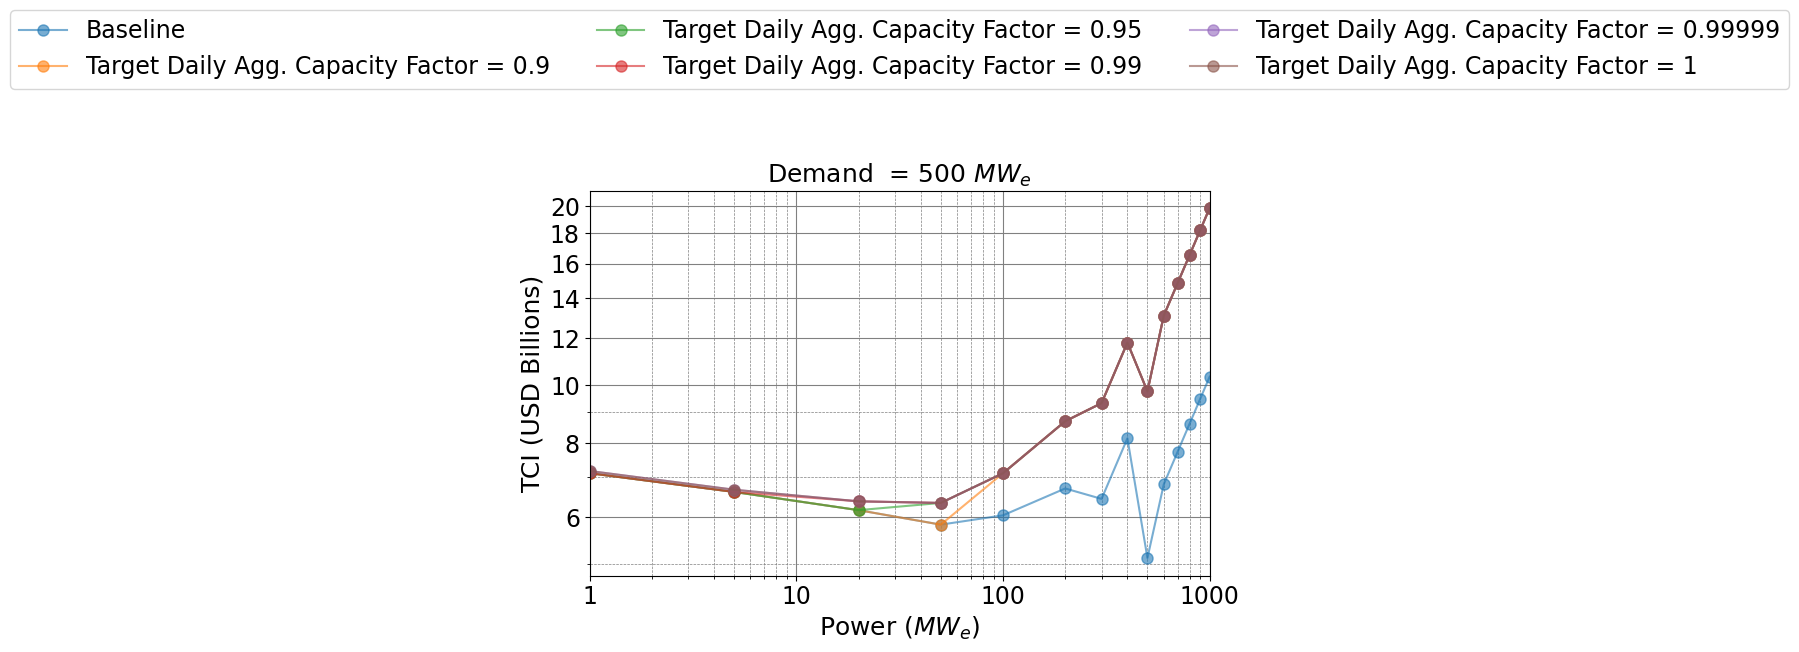

1000 Baseline
1000 0.9
1000 0.95
1000 0.99
1000 0.99999
1000 1


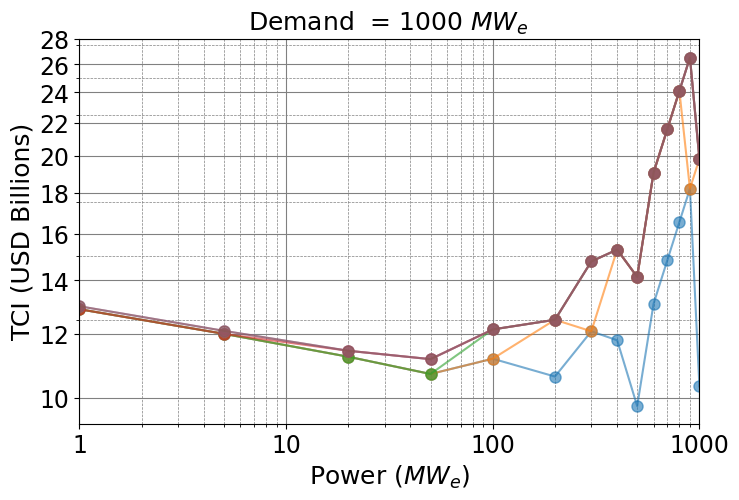

3000 Baseline
3000 0.9
3000 0.95
3000 0.99
3000 0.99999
3000 1


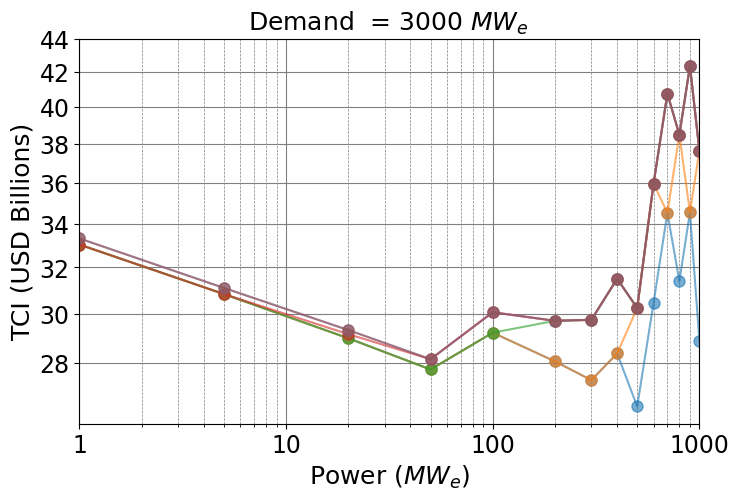

6000 Baseline
6000 0.9
6000 0.95
6000 0.99
6000 0.99999
6000 1


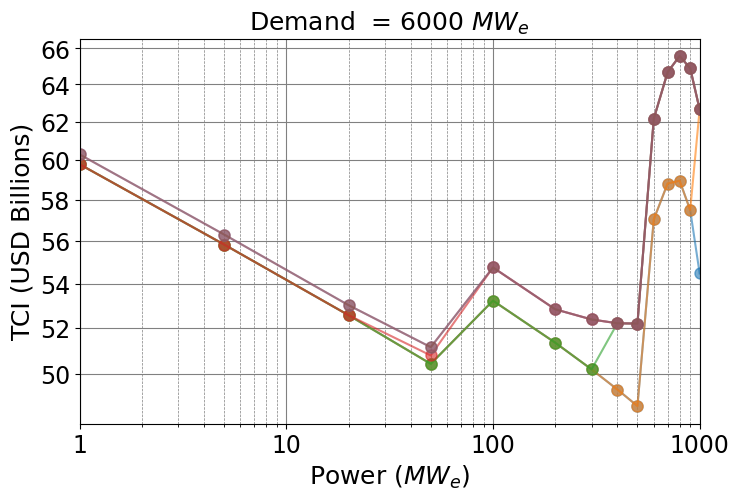

In [57]:
import matplotlib as mpl

# delete the output file is exists
filename = "TCI_for_demand_reliability.csv"
try:
    os.remove(filename)
except OSError:
    pass
    
power_list = [1000, 900 , 800, 700, 600, 500, 400, 300, 200, 100  ,50,  20, 5, 1]
min_capacity_factor_criteria_list = ['Baseline' ,0.9, 0.95,  0.99, 0.99999, 1]
interest_rate = 0.06
levelization_period_0 = int(365 * 30/7)
overall_capacity_factor_criteria = 0 # has no effect



for tot_demand in [500,  1000, 3000, 6000] :
    fig = plt.figure(figsize=(8, 5))
    plt.title( f"Demand  = {tot_demand} $MW_e$ ",  fontsize=18)
    for min_capacity_factor_criteria in min_capacity_factor_criteria_list:
        tot_TCI_list = []

        print(tot_demand, min_capacity_factor_criteria)
        for reactor_power in power_list:

            fuel_lifetime = operational_lifetime_estimate(reactor_power) 
            refueling_period =  refueling_period_estimate(reactor_power) 
            
            if min_capacity_factor_criteria == "Baseline":
               num_reactors_needed = int(np.ceil(num_reactors_needed_for_capacity_factor_weeks_apprioach(overall_capacity_factor_criteria,\
                            0, fuel_lifetime, refueling_period, reactor_power ,\
                                levelization_period_0, tot_demand))) 
            else:
            
                num_reactors_needed = int(np.ceil(num_reactors_needed_for_capacity_factor_weeks_apprioach(overall_capacity_factor_criteria,\
                            min_capacity_factor_criteria, fuel_lifetime, refueling_period, reactor_power ,\
                                levelization_period_0, tot_demand)))

            tot_TCI = (tot_TCI_multiple_reactors (reactor_power, interest_rate, num_reactors_needed)) / 1000000000
            tot_TCI_list.append(tot_TCI)
        
        # save it into a list
        df1 = pd.DataFrame(tot_TCI_list)
        df1.to_csv(filename , mode='a',index = False)
        
        if min_capacity_factor_criteria == "Baseline" :
            plt.plot(power_list , tot_TCI_list , '-o' , markersize = 8,  alpha=0.6 ,label = "Baseline")
        else:
            plt.plot(power_list , tot_TCI_list , '-o' , markersize = 8,  alpha=0.6 ,label = f"Target Daily Agg. Capacity Factor = { min_capacity_factor_criteria}")

           
        plt.yscale('log')
        plt.xscale('log')
    if tot_demand == 500:
        plt.legend(bbox_to_anchor=(0.5, 1.5), loc='upper center', fontsize=17 , ncol=3)


    
    plt.grid(which='major', color='grey', linewidth=0.8)
    plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
    plt.minorticks_on() 
    
    # 
    # plt.gca().yaxis.set_minor_locator(plt.FixedLocator([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]))
    # plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter(''))
    # ax.xaxis.set_major_formatter(FormatStrFormatter('% 1.2f')) 
    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    
    plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().xaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    
    ticks_list = np.linspace( 2*np.floor((min(tot_TCI_list))/2)    , 2*np.ceil((max(tot_TCI_list))/2), int(1    +    np.ceil((max(tot_TCI_list))/2)   -    np.floor((min(tot_TCI_list))/2)   )  )
    plt.yticks( ticks_list)
    
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    plt.gca().xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
   
    
    # plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2))
    
    plt.xlabel('Power ($MW_e$)', fontsize=18)
    plt.ylabel('TCI (USD Billions)', fontsize=18) 
    # plt.ylim(0,  10*np.ceil(max(tot_TCI_list)/10)          )
    plt.xlim( 1, 1000)
    
    plt.yticks(fontsize=17)
    plt.xticks(fontsize=17) 
    plt.savefig(f'TCI_{tot_demand}.png', bbox_inches='tight')
    plt.show()